In [1]:
import numpy as np

In [2]:
print("Expected cross entropy loss if the model: ")
print(" - learns neither dependency:", -(0.625*np.log(0.625) + 0.375 * np.log(0.375)))

# learns first dependency only ==> 0.519166
print(" - learns first dependency:", -0.5 * (0.875 * np.log(0.875) + 0.125 * np.log(0.125))
                                      - 0.5  * (0.8625 * np.log(0.625) + 0.375 * np.log(0.375)))
# learns first dependency only ==> 0.519166
print(" - learns both dependency:", -0.5 * (0.750 * np.log(0.75) + 0.25 * np.log(0.25)) 
                                      - 0.25  * (2 * 0.50 * np.log(0.5)) 
                                      -  0.25 * (0))

Expected cross entropy loss if the model: 
 - learns neither dependency: 0.661563238158
 - learns first dependency: 0.57497963068
 - learns both dependency: 0.454454367449


## Model architecture

The model will be as simple as possible: at time step t, for 
t
∈
{
0
,
1
,
…
n
}
t∈{0,1,…n} the model accepts a (one-hot) binary 
X
t
Xt vector and a previous state vector, 
S
t
−
1
St−1, as inputs and produces a state vector, 
S
t
St, and a predicted probability distribution vector, 
P
t
Pt, for the (one-hot) binary vector 
Y
t
Yt.

Formally, the model is:


St=tanh(W(Xt @ St−1)+bs)

Pt=softmax(USt+bp)
<img src="data/BasicRNN.png" >

The usual pattern for dealing with very long sequences is therefore to “truncate” our backpropagation by backpropagating errors a maximum of 
n
n steps. We choose 
n
n as a hyperparameter to our model, keeping in mind the trade-off: higher 
n
n lets us capture longer term dependencies, but is more expensive computationally and memory-wise.
A natural interpretation of backpropagating errors a maximum of 
n
n steps means that we backpropagate every possible error 
n
n steps. That is, if we have a sequence of length 49, and choose 
n
=
7
n=7, we would backpropagate 42 of the errors the full 7 steps.


[Truncated backpropagation] is easy to implement by feeding inputs of length [
n
n] at a time and doing backward pass after each iteration.”). This means that we would take our sequence of length 49, break it up into 7 sub-sequences of length 7 that we feed into the graph in 7 separate computations, and that only the errors from the 7th input in each graph are backpropagated the full 7 steps. Therefore, even if you think there are no dependencies longer than 7 steps in your data, it may still be worthwhile to use 
n
>
7
n>7 so as to increase the proportion of errors that are backpropagated by 7 steps

<img src="data/BasicRNNLabeled.png" >

In [3]:
import numpy as np
import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plt

In [4]:
# Global config variables
num_steps = 5 # number of truncated backprop steps
batch_size = 200
num_classes = 2
state_size = 4
learning_rate = 0.01

In [5]:
def gen_data(size=1000000):
    X = np.array(np.random.choice(2, size=(size,)))
    Y = []
    for i in range(size):
        threshold = 0.5
        if X[i-3] == 1:
            threshold += 0.5
        if X[i-8] == 1:
            threshold -= 0.25
        if np.random.rand() > threshold:
            Y.append(0)
        else:
            Y.append(1)
    return X, np.array(Y)

In [6]:
def gen_batch(raw_data, batch_size, num_steps):
    raw_x, raw_y = raw_data
    data_length = len(raw_x)
    
    # partition raw_data into batches and stack them vertically in a data matrix
    batch_partition_length = data_length // batch_size
    
    data_x = np.zeros([batch_size, batch_partition_length], dtype=np.int32)
    data_y = np.zeros([batch_size, batch_partition_length], dtype=np.int32)
    
    for i in range(batch_size):
        data_x[i] = raw_x[batch_partition_length * i : batch_partition_length * (i + 1)]
        data_y[i] = raw_y[batch_partition_length * i : batch_partition_length * (i + 1)]
    
    # further divide batch partition into num_steps for truncated backprop
    epoch_size = batch_partition_length // num_steps
    
    for i in range(epoch_size):
        x = data_x[:, i * num_steps : (i + 1) * num_steps]
        y = data_y[:, i * num_steps : (i + 1) * num_steps]
        print(x.shape, y.shape)
        yield (x, y)    

In [7]:
def gen_epochs(n, num_steps):
    for i in range(n):
        yield gen_batch(gen_data(), batch_size, num_steps)

# Model

In [8]:
# placeholders
x = tf.placeholder(tf.int32, [batch_size, num_steps], name='input_placeholder')
y = tf.placeholder(tf.int32, [batch_size, num_steps], name='input_placeholder')
init_state = tf.zeros([batch_size, state_size])

# RNN inputs

x_one_hot = tf.one_hot(x, num_classes)
rnn_inputs = tf.unstack(x_one_hot, axis=1)
print("rnn_inputs shape:", len(rnn_inputs))

rnn_inputs shape: 5


In [9]:
# definition of rnn cell
with tf.variable_scope('rnn_cell'):
    W = tf.get_variable('W', [num_classes + state_size, state_size])
    b = tf.get_variable('b', [state_size], initializer=tf.constant_initializer(0.0))

def rnn_cell(rnn_input, state):
    with tf.variable_scope('rnn_cell', reuse=True):
        W = tf.get_variable('W', [num_classes + state_size, state_size])
        b = tf.get_variable('b', [state_size], initializer=tf.constant_initializer(0.0))
        #print('rnn_input shape', rnn_input.shape)
        #print('state shape', state.shape)
    return tf.tanh(tf.matmul(tf.concat([rnn_input, state], 1), W) + b) 
    
    

In [10]:
# adding rnn to graph
state = init_state
rnn_outputs = []
for rnn_input in rnn_inputs:
    state = rnn_cell(rnn_input, state)
    rnn_outputs.append(state)
final_state = rnn_outputs[-1]

rnn_input shape (200, 2)
state shape (200, 4)
rnn_input shape (200, 2)
state shape (200, 4)
rnn_input shape (200, 2)
state shape (200, 4)
rnn_input shape (200, 2)
state shape (200, 4)
rnn_input shape (200, 2)
state shape (200, 4)


In [11]:
# training

with tf.variable_scope('softmax'):
    W = tf.get_variable('W', [state_size, num_classes])
    b = tf.get_variable('b', [num_classes], initializer=tf.constant_initializer(0.0))
logits = [tf.matmul(rnn_output, W) + b for rnn_output in rnn_outputs]
predictions = [tf.nn.softmax(logit) for logit in logits]

# turn our y placeholder into a list of labels
y_as_list = tf.unstack(y, num=num_steps, axis=1)

# loss and train_step
losses = [tf.nn.sparse_softmax_cross_entropy_with_logits(labels=label, logits=logit) 
          for logit, label in zip(logits, y_as_list)]
total_loss = tf.reduce_mean(losses)
train_step = tf.train.AdamOptimizer(learning_rate).minimize(total_loss)



In [12]:
# train the network
def train_network(num_epochs, num_steps, state_size=4, verbose=True):
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        training_losses = []
        for idx, epoch, in enumerate(gen_epochs(num_epochs, num_steps)):
            training_loss = 0
            training_state = np.zeros((batch_size, state_size))
            if verbose:
                print('\nEPOCH', idx)
            for step, (X, Y) in enumerate(epoch):
                tr_losses, training_loss_, training_state, _ = sess.run([losses,
                                                                         total_loss,
                                                                         final_state,
                                                                         train_step], 
                                                                        feed_dict={x:X,
                                                                                   y:Y,
                                                                                   init_state:training_state})
                training_loss += training_loss_
                if step % 100 == 0 and step > 0:
                    if verbose:
                        print("average loss at step ", step, ' for last 250 steps: ', training_loss/100)
                    training_losses.append(training_loss/100)
                    training_loss = 0
        return training_losses
                    
                
    


EPOCH 0
(200, 5) (200, 5)
(200, 5) (200, 5)
(200, 5) (200, 5)
(200, 5) (200, 5)
(200, 5) (200, 5)
(200, 5) (200, 5)
(200, 5) (200, 5)
(200, 5) (200, 5)
(200, 5) (200, 5)
(200, 5) (200, 5)
(200, 5) (200, 5)
(200, 5) (200, 5)
(200, 5) (200, 5)
(200, 5) (200, 5)
(200, 5) (200, 5)
(200, 5) (200, 5)
(200, 5) (200, 5)
(200, 5) (200, 5)
(200, 5) (200, 5)
(200, 5) (200, 5)
(200, 5) (200, 5)
(200, 5) (200, 5)
(200, 5) (200, 5)
(200, 5) (200, 5)
(200, 5) (200, 5)
(200, 5) (200, 5)
(200, 5) (200, 5)
(200, 5) (200, 5)
(200, 5) (200, 5)
(200, 5) (200, 5)
(200, 5) (200, 5)
(200, 5) (200, 5)
(200, 5) (200, 5)
(200, 5) (200, 5)
(200, 5) (200, 5)
(200, 5) (200, 5)
(200, 5) (200, 5)
(200, 5) (200, 5)
(200, 5) (200, 5)
(200, 5) (200, 5)
(200, 5) (200, 5)
(200, 5) (200, 5)
(200, 5) (200, 5)
(200, 5) (200, 5)
(200, 5) (200, 5)
(200, 5) (200, 5)
(200, 5) (200, 5)
(200, 5) (200, 5)
(200, 5) (200, 5)
(200, 5) (200, 5)
(200, 5) (200, 5)
(200, 5) (200, 5)
(200, 5) (200, 5)
(200, 5) (200, 5)
(200, 5) (200, 5)
(

(200, 5) (200, 5)
(200, 5) (200, 5)
(200, 5) (200, 5)
(200, 5) (200, 5)
(200, 5) (200, 5)
(200, 5) (200, 5)
(200, 5) (200, 5)
(200, 5) (200, 5)
(200, 5) (200, 5)
(200, 5) (200, 5)
(200, 5) (200, 5)
(200, 5) (200, 5)
(200, 5) (200, 5)
(200, 5) (200, 5)
(200, 5) (200, 5)
(200, 5) (200, 5)
(200, 5) (200, 5)
(200, 5) (200, 5)
(200, 5) (200, 5)
(200, 5) (200, 5)
(200, 5) (200, 5)
(200, 5) (200, 5)
(200, 5) (200, 5)
(200, 5) (200, 5)
(200, 5) (200, 5)
(200, 5) (200, 5)
(200, 5) (200, 5)
(200, 5) (200, 5)
(200, 5) (200, 5)
(200, 5) (200, 5)
(200, 5) (200, 5)
(200, 5) (200, 5)
(200, 5) (200, 5)
(200, 5) (200, 5)
(200, 5) (200, 5)
(200, 5) (200, 5)
(200, 5) (200, 5)
(200, 5) (200, 5)
(200, 5) (200, 5)
(200, 5) (200, 5)
(200, 5) (200, 5)
(200, 5) (200, 5)
(200, 5) (200, 5)
(200, 5) (200, 5)
(200, 5) (200, 5)
(200, 5) (200, 5)
(200, 5) (200, 5)
(200, 5) (200, 5)
(200, 5) (200, 5)
(200, 5) (200, 5)
(200, 5) (200, 5)
(200, 5) (200, 5)
average loss at step  500  for last 250 steps:  0.525886330307
(

(200, 5) (200, 5)
(200, 5) (200, 5)
(200, 5) (200, 5)
(200, 5) (200, 5)
(200, 5) (200, 5)
(200, 5) (200, 5)
(200, 5) (200, 5)
(200, 5) (200, 5)
(200, 5) (200, 5)
(200, 5) (200, 5)
(200, 5) (200, 5)
(200, 5) (200, 5)
(200, 5) (200, 5)
(200, 5) (200, 5)
(200, 5) (200, 5)
(200, 5) (200, 5)
(200, 5) (200, 5)
(200, 5) (200, 5)
(200, 5) (200, 5)
(200, 5) (200, 5)
(200, 5) (200, 5)
(200, 5) (200, 5)
(200, 5) (200, 5)
(200, 5) (200, 5)
(200, 5) (200, 5)
(200, 5) (200, 5)
(200, 5) (200, 5)
(200, 5) (200, 5)
(200, 5) (200, 5)
(200, 5) (200, 5)
(200, 5) (200, 5)
(200, 5) (200, 5)
(200, 5) (200, 5)
(200, 5) (200, 5)
(200, 5) (200, 5)
(200, 5) (200, 5)
(200, 5) (200, 5)
(200, 5) (200, 5)
(200, 5) (200, 5)
(200, 5) (200, 5)
(200, 5) (200, 5)
(200, 5) (200, 5)
(200, 5) (200, 5)
(200, 5) (200, 5)
(200, 5) (200, 5)
(200, 5) (200, 5)
(200, 5) (200, 5)
(200, 5) (200, 5)
(200, 5) (200, 5)
(200, 5) (200, 5)
(200, 5) (200, 5)
(200, 5) (200, 5)
(200, 5) (200, 5)
(200, 5) (200, 5)
(200, 5) (200, 5)
(200, 5) (

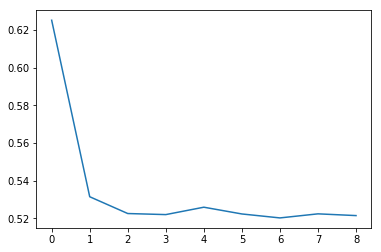

In [13]:
training_losses = train_network(1, num_steps)
plt.plot(training_losses)

In [15]:
# in another file
import basic_rnn
def plot_learning_curve(num_steps, state_size=4, epochs=1):
    global losses, total_loss, final_state, train_step, x, y, init_state
    tf.reset_default_graph()
    g = tf.get_default_graph()
    losses, total_loss, final_state, train_step, x, y, init_state = basic_rnn.setup_graph(
                                                                                g, 
                                                                                basic_rnn.RNN_config(
                                                                                num_steps=num_steps,
                                                                                state_size=state_size)
                                                                                )
    res = train_network(epochs, num_steps, state_size=state_size, verbose=False)
    plt.plot(res)

In [16]:
plot_learning_curve(num_steps=1, state_size=4, epochs=2)

NameError: name 'setup_graph' is not defined